In [1]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import  Path
import pickle

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=True, thresholds=[0.8, 0.9, 0.9])
resnet = InceptionResnetV1(classify=False, pretrained='vggface2').to(device)
resnet.eval()
database_path = "../../models/face_database_all_v2.pkl"

In [4]:
try:
    with open(database_path, 'rb') as f:
        database = pickle.load(f)
        known_embeddings = database['embeddings']
        known_names = database['names']
        classes = database['classes']
    print(f"Database loaded: {len(known_embeddings)} embeddings")
    print(f"known people: {classes}")
except:
    print("database not found")

Database loaded: 2000 embeddings
known people: ['Bellingham', 'Dai', 'Duong', 'Henry', 'Neymar', 'Nguyen', 'Obama', 'Ronaldo', 'Thuong', 'Trump']


In [5]:
img_path = "/home/monarch/Pictures/Screenshots/2025-06-21_18-11-35.png"
threshold = 0.85

img = cv2.imread(img_path)
rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgb_image)

In [6]:
boxes, probs = mtcnn.detect(pil_image)
print(f"Detected {len(boxes) if boxes is not None else 0} faces")

Detected 11 faces


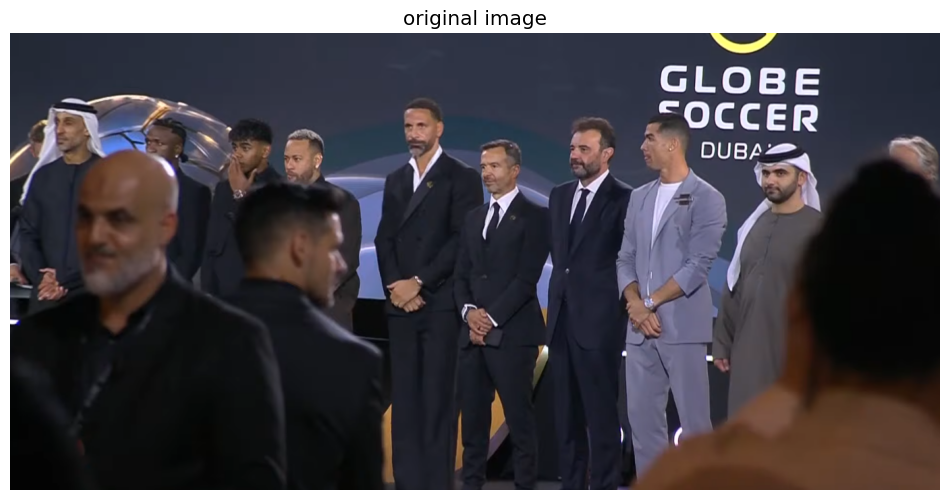

In [7]:
plt.imshow(rgb_image)
plt.title("original image")
plt.axis('off')
plt.show()

In [8]:
if boxes is not None:
    face_tensors = mtcnn.extract(pil_image, boxes, save_path=None)
    results = []
    for i, (box, face_tensors) in enumerate(zip(boxes, face_tensors)):
        if face_tensors is not None:
            with torch.no_grad():
                face_tensors = face_tensors.to(device).unsqueeze(0)
                embedding = resnet(face_tensors).cpu().numpy().flatten()
            dists = [np.linalg.norm(embedding - known_embed) for known_embed in known_embeddings]
            min_dist = min(dists)
            
            if min_dist < threshold:
                best_match_idx = dists.index(min_dist)
                name = known_names[best_match_idx]
            else:
                name = "Unknown"
            results.append({
                'box': box.astype(int),
                'name': name,
                'distance': min_dist
            })
            
            print(f"face {i+1}: {name} (distance: {min_dist:.3f})")

face 1: Unknown (distance: 1.025)
face 2: Unknown (distance: 0.912)
face 3: Unknown (distance: 1.074)
face 4: Unknown (distance: 1.113)
face 5: Ronaldo (distance: 0.766)
face 6: Unknown (distance: 1.108)
face 7: Unknown (distance: 1.178)
face 8: Neymar (distance: 0.841)
face 9: Unknown (distance: 1.027)
face 10: Unknown (distance: 0.896)
face 11: Unknown (distance: 1.135)


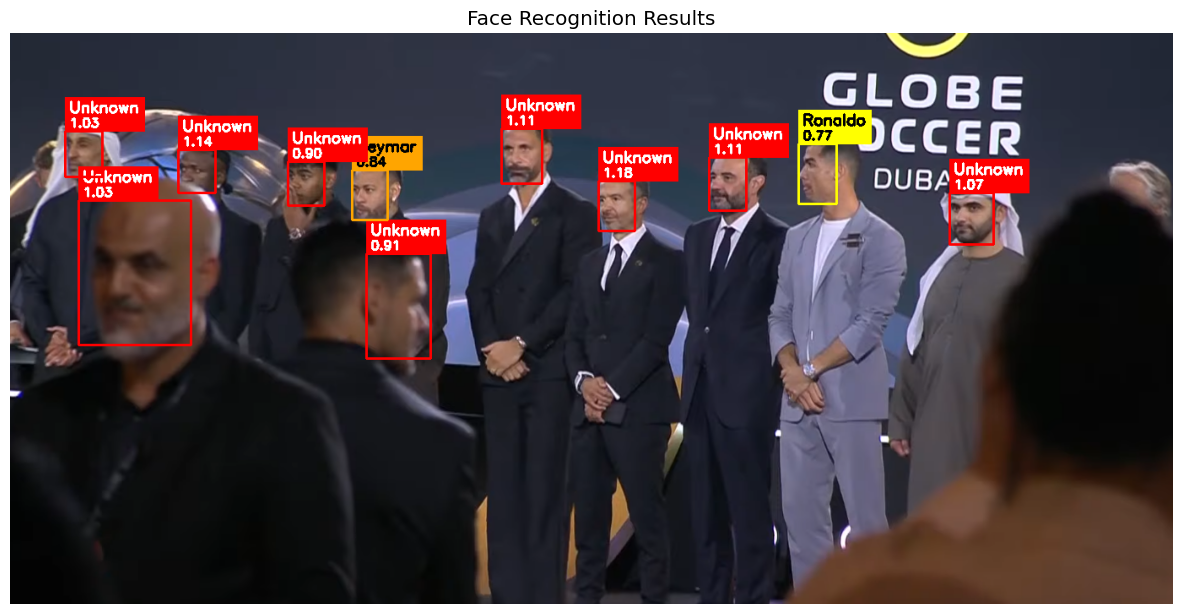

In [9]:
res_img = img.copy()

for res in results:
    left, top, right, bottom = res['box']
    name = res['name']
    dist = res['distance']
    
    if name == "Unknown":
        color = (0, 0, 255)
        text_color = (255, 255, 255)
    elif dist <= 0.6:
        color = (0, 255, 0)
        text_color = (0, 0, 0)
    elif dist <= 0.8:
        color = (0, 255, 255)
        text_color = (0, 0, 0)
    else:
        color = (0, 165, 255)
        text_color = (0, 0, 0)
    
    name_size = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
    dist_size = cv2.getTextSize(f"{dist:.2f}", cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
    
    label_width = max(name_size[0], dist_size[0]) + 10
    label_height = 40
    
    cv2.rectangle(res_img, (left, top), (right, bottom), color, 2)
    cv2.rectangle(res_img, (left, top-label_height), (left+label_width, top), color, -1)
    cv2.putText(res_img, name, (left+5, top-22), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
    cv2.putText(res_img, f"{dist:.2f}", (left+5, top-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
plt.title("Face Recognition Results")
plt.axis('off')
plt.show()